## Import Packages and Load Data

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from preprocess import * 
import xgboost
import umap
import umap.plot
import warnings
warnings.filterwarnings('ignore')

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
train_data = pd.read_csv(os.path.join("data", "train.csv"))
test_data = pd.read_csv(os.path.join("data", "test.csv"))
train_data["description"].fillna("", inplace=True)
train_data["host_is_superhost"].fillna("f", inplace=True)
train_data["beds"].fillna("1", inplace=True)
train_data.dropna(inplace=True)
X, y = train_data.drop(["price"], axis=1), train_data["price"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_test = test_data
X_train, X_val, X_test = preprocess(X_train), preprocess(X_val), preprocess(X_test)

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class AirBnbDataset(Dataset): 
    
    def __init__(self, X, y): 
        
        # First, train the scaler to the preprocessed train set only 
        scaler = StandardScaler() 
        scaler.fit(X_train) 
        
        # now, convert this pandas dataframe to a numpy array and scale it 
        X = X.to_numpy().astype(float)
        X = scaler.transform(X) 
        
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = y.to_numpy().astype(int)
        self.num_features = self.X.size()[1]
        
    def process_into_tensor(self): 
        scaler = StandardScaler() 
        scaler.fit(X) 
    
    def __len__(self): 
        return self.X.size()[0] 
    
    def __getitem__(self, i): 
        return (self.X[i, :], self.y[i])

trainset = AirBnbDataset(X_train, y_train) 
valset = AirBnbDataset(X_val, y_val)

trainloader = DataLoader(trainset,    # our dataset
                              batch_size=512,    # batch size
                              shuffle=True      # shuffling the data
                            )
valloader = DataLoader(valset, batch_size=512, shuffle=True)

In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(), 
            nn.Linear(128, 6)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
def oneHot(y): 
    one_hot = torch.zeros(len(y), 6)
    for idx, class_num in enumerate(y):
        one_hot[idx, class_num] = 1 
    return one_hot

def train(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, oneHot(y).to(device))

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return loss 
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, oneHot(y).to(device)).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss 

In [24]:
model = NeuralNetwork(trainset.num_features).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),     # which parameters to optimize
    lr=3e-3,                 # learning rate 
    momentum=0.9, 
    weight_decay=1e-2
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)

epochs = 71
train_losses, val_losses = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(trainloader, model, loss_fn, optimizer, scheduler))
    val_losses.append(test(valloader, model, loss_fn))
    scheduler.step() 
    # print(f"lr : {optimizer.lr}")
print("Done!")

Epoch 1
-------------------------------
loss: 1.789956  [  512/11740]
Test Error: 
 Accuracy: 27.6%, Avg loss: 1.778760 

Epoch 2
-------------------------------
loss: 1.779579  [  512/11740]
Test Error: 
 Accuracy: 27.4%, Avg loss: 1.759221 

Epoch 3
-------------------------------
loss: 1.769646  [  512/11740]
Test Error: 
 Accuracy: 27.4%, Avg loss: 1.744964 

Epoch 4
-------------------------------
loss: 1.751692  [  512/11740]
Test Error: 
 Accuracy: 27.4%, Avg loss: 1.734066 

Epoch 5
-------------------------------
loss: 1.730467  [  512/11740]
Test Error: 
 Accuracy: 27.4%, Avg loss: 1.724646 

Epoch 6
-------------------------------
loss: 1.722654  [  512/11740]
Test Error: 
 Accuracy: 27.4%, Avg loss: 1.715619 

Epoch 7
-------------------------------
loss: 1.714631  [  512/11740]
Test Error: 
 Accuracy: 27.4%, Avg loss: 1.704896 

Epoch 8
-------------------------------
loss: 1.714234  [  512/11740]
Test Error: 
 Accuracy: 27.4%, Avg loss: 1.695642 

Epoch 9
----------------

Text(0, 0.5, 'Loss')

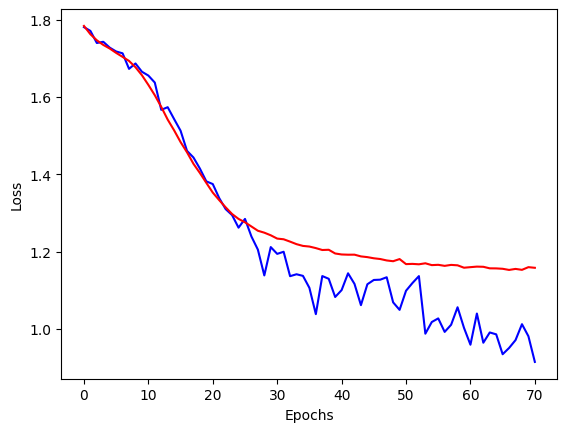

In [15]:
plt.plot([x.detach().cpu().numpy() for x in train_losses], c="b", label="Train Loss")
plt.plot([x for x in val_losses], c="r", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [38]:
from sklearn.metrics import classification_report

# Compute scores 

scaler = StandardScaler() 
scaler.fit(X_train) 

X_val_input = X_val.to_numpy().astype(float)
X_val_input = scaler.transform(X_val_input) 
X_val_input = torch.tensor(X_val_input, dtype=torch.float32).to(device)

x_test_pred = model(X_val_input)
x_test_pred = x_test_pred.argmax(1)


print(classification_report(y_val, x_test_pred.detach().cpu().numpy(), digits=5))

              precision    recall  f1-score   support

         0.0    0.70507   0.82960   0.76229       804
         1.0    0.41815   0.42190   0.42002       557
         2.0    0.33141   0.22374   0.26713       514
         3.0    0.44167   0.51556   0.47576       514
         4.0    0.42462   0.43949   0.43192       314
         5.0    0.74194   0.49569   0.59432       232

    accuracy                        0.52300      2935
   macro avg    0.51048   0.48766   0.49191      2935
weighted avg    0.51196   0.52300   0.51182      2935

